<a href="https://colab.research.google.com/github/mateosuster/nlpPapers/blob/main/code/05_LDA_TopicModels_GENSIM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [1]:
%%capture
!pip install pyLDAvis==2.1.2

import os
from google.colab import files
from gensim.test.utils import datapath

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter


from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

# LDA

In [2]:
### LDA TOPICS:
# params
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 19     ### INGRESE CANT. OPTIMA DE TOPICOS (En principio: 19, 20, 26, ó 12). 

# data
from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

#cleaning
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

#dictionaries
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()

Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
Coherence_Media_Ponderada = Coherence_Media/ Coherence_Total 

print('Nro. Topics Optimo: %.2f ' % (Cant_Optima_Topics))
print('Coherencia Media: %.2f ' % (round(Coherence_Total,2)))
print('Coherencia Total: %.2f ' % (round(Coherence_Media,2)))
print('Coherencia Total: %.2f ' % (round(Coherence_Media_Ponderada,2)))
print(" ")



Nro. Topics Optimo: 19.00 
Coherencia Media: 0.19 
Coherencia Total: 0.01 
Coherencia Total: 0.05 
 


# Save models

In [ ]:


# Save models to disk.
temp_file = datapath("/content/lda")
ldamodel_optimo.save(temp_file)

# Dowload models
path = "/content/"
dir_list = os.listdir(path)

for i in dir_list:
  if 'lsa' in i or 'lda' in i  :
    print('downloading')
    files.download(path + i)


downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Distribucion de los topicos por año

Para un documento en particular

In [3]:
new_text = dataset[0]

# transform held_out_text into the bag-of-words space
bow_vector = dictionary.doc2bow(word_tokenize(new_text))
lda_vector = ldamodel_optimo[bow_vector]
print(lda_vector) # imprime las probabilidades de cada topico

# print the document's single most prominent LDA topic (palabras mas frecuentes de topico mas probable )
print(ldamodel_optimo.print_topic(max(lda_vector, key=lambda item: item[1])[0]))

[(5, 0.10281016), (8, 0.13089703), (12, 0.016162451), (13, 0.743914)]
0.025*"word" + 0.017*"words" + 0.010*"embeddings" + 0.010*"method" + 0.008*"similarity" + 0.008*"different" + 0.008*"language" + 0.007*"bias" + 0.007*"linguistic" + 0.007*"using"


Cargo todos los papers y corro el LDA sobre ellos y Aplico el mismo preprocesamiento


In [4]:
papers_text  = [tokenize(str(doc).lower()) for doc in data_Total.ABSTRACT]
papers_text_df = pd.DataFrame([' '.join(text) for text in papers_text], columns = ['text'])

papers_text_df

,text
0,text worlds virtual environments embodied agen...
1,prototype system playing minimal improvisation...
2,characters npcs significantly enhance player e...
3,interactive question answering iqa requires in...
4,purpose extended abstract discuss possible fru...
...,...
33806,paper deals problem representing useful form w...
33807,becomes evident successful pragmatics automati...
33808,establishing grammatical description language ...
33809,grammar based upon conventional morphemic anal...


In [5]:
papers_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33811 entries, 0 to 33810
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33811 non-null  object
dtypes: object(1)
memory usage: 264.3+ KB


In [6]:
results = []

for text_i in papers_text_df.text:

  # transform held_out_text into the bag-of-words space
  bow_vector = dictionary.doc2bow(word_tokenize(str(text_i)))
  lda_vector_i = ldamodel_optimo[bow_vector]

  # converting to dict
  result = dict(lda_vector_i)
  results.append(result)

topics_dis = pd.DataFrame(results)
topics_dis['year'] = data_Total.YEAR 
topics_dis = topics_dis.melt(id_vars = 'year', var_name='topic', value_name='prob')
topics_dis

,year,topic,prob
0,2022,1,0.168953
1,2022,1,NaN
2,2022,1,0.035769
3,2022,1,0.067187
4,2022,1,0.214618
...,...,...,...
642404,1963,16,NaN
642405,1963,16,0.011574
642406,1963,16,NaN
642407,1963,16,NaN


In [7]:
topics_dis_agg = topics_dis.groupby(['year', 'topic' ], as_index= False).agg(
    {'prob' : ['mean', 'median', 'std', 'count'] }
     )

topics_dis_agg.column = ['year', 'topic' , 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg = topics_dis_agg.reset_index()
topics_dis_agg.columns

MultiIndex([('index',       ''),
            ( 'year',       ''),
            ('topic',       ''),
            ( 'prob',   'mean'),
            ( 'prob', 'median'),
            ( 'prob',    'std'),
            ( 'prob',  'count')],
           )

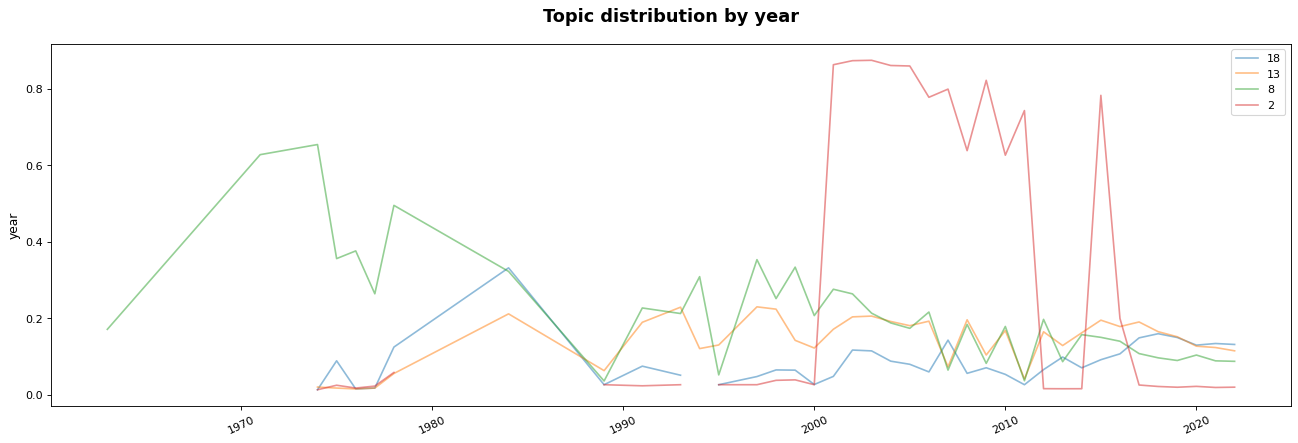

In [8]:
topics2viz = [18, 13, 8, 2]
viz_all = False

fig = plt.figure(figsize=(20, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plt.ylabel("year", fontsize=11)
plt.xticks(rotation=25)  # Rotates X-Axis Ticks by 45-degrees
# plt.xlabel('Days')

# displaying the title
plt.title(
    "Topic distribution by year", fontsize=16, fontweight="bold", pad=20
)
if viz_all == True:
  for i in topics_dis_agg.topic.unique():
      ax.plot(
          topics_dis_agg[topics_dis_agg["topic"] == i]["year"],
          topics_dis_agg[topics_dis_agg["topic"] == i]["prob", "median"],
          label=(i),
          # color="green",
          # color="#e41a1c",
          alpha=0.5,)
else: 
   for i in topics2viz:
      ax.plot(
          topics_dis_agg[topics_dis_agg["topic"] == i]["year"],
          topics_dis_agg[topics_dis_agg["topic"] == i]["prob", "median"],
          label=(i),
          # color="green",
          # color="#e41a1c",
          alpha=0.5,)


ax.legend()
plt.show()

In [9]:
topics_dis_agg.to_csv('topic_distribution_year.csv', index = False)
files.download('/content/topic_distribution_year.csv')

NameError: ignored

# Visualizacion de distribucion de topicos

In [ ]:
### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.206856  0.068989       1        1  20.068320
13    -0.184161  0.050953       2        1  12.111227
9     -0.138949  0.082048       3        1  10.611284
8     -0.134225  0.003875       4        1   8.812806
5     -0.186684  0.109770       5        1   8.223380
2      0.362844  0.247323       6        1   7.536012
18    -0.161440  0.072927       7        1   7.209816
17    -0.113271  0.102331       8        1   4.387667
4     -0.093600 -0.000228       9        1   3.826021
7     -0.119262  0.024523      10        1   3.751445
3     -0.024229 -0.107821      11        1   2.481728
6     -0.038201 -0.061046      12        1   2.153106
10    -0.019580 -0.109647      13        1   2.128405
15     0.355844  0.252074      14        1   2.016045
11     0.028475 -0.093739      15        1   1.907265
1      0.052269 -0.185992      16        1   1.749866
0      0.193013 -0.196002      17        1   0.369397
16     0.236307 -0.091147      18        1   0.355887
12     0.191705 -0.169190      19        1   0.300327, topic_info=             Term          Freq         Total Category  logprob  loglift
279            de   9968.000000   9968.000000  Default  30.0000  30.0000
286            et   4200.000000   4200.000000  Default  29.0000  29.0000
354         model  11347.000000  11347.000000  Default  28.0000  28.0000
72    translation   6653.000000   6653.000000  Default  27.0000  27.0000
1296       models  10545.000000  10545.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
4979         axes     27.082151     28.098659  Topic19  -5.0441   5.7712
3770      augment    194.108508    225.778826  Topic19  -3.0746   5.6569
4458      adapter     62.974068     73.598170  Topic19  -4.2003   5.6522
2781     messages    157.936017    215.374388  Topic19  -3.2808   5.4979
4201           av     49.077167     71.772933  Topic19  -4.4496   5.4279

[1109 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6415      8  0.991402  ablation
7722      8  0.986608      absa
144       2  0.051916  abstract
144       7  0.057684  abstract
144      10  0.092295  abstract
...     ...       ...       ...
1563      8  0.021269     years
1563     11  0.001519     years
1563     12  0.006077     years
5710     18  0.962451      york
3834      2  0.990713      zero

[2413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 10, 9, 6, 3, 19, 18, 5, 8, 4, 7, 11, 16, 12, 2, 1, 17, 13])

lambda 
* cercano a 1 muestra las palabras mas probables de cada topico
* cercano a 0 muestra las palabras mas especificas de cada topico (palabras raras, altamente probables en ese topico y poco probables en los otros). Son palabras muy asociados al topico y son palabras poco probables. Serian palabras diferencialmente mas probables para del topico (pueden ser palabras poco proablbes para el topico pq son poco proablabes en si)´


el grafico de la izquierda muestra los topicos distribuidos espacialmente segun si tienen palabras parecidas